In [2]:
import pandas as pd
import numpy as np
import squarify
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

today_date = pd.to_datetime('2022-04-15')

# RFM

In [3]:
trx_cenabast_ = pd.read_excel('Datos.xlsx')
trx_cenabast = trx_cenabast_.copy()

In [4]:
trx_cenabast.head(5)

,ZGEN,Documento comercial,Material,Denominación,Solicitante,Nombre 1,Clte(DM),Fecha documento,mes,Año,...,Jerarquía DT,Precio Venta Cenabast Bruto,Precio Máximo Venta al Público,Precio Promedio Ponderado Retail,Nombre Proveedor,Region,Comuna,Puesto de Descarga,Latitude,Longitude
0,100000903,306344037,500011462,PROLOPA 200/50 MG FRA 30 CM,77208124,FARMACIAS DEL SUR SPA,204264,2021-08-09,8,2021,...,Antiparkinsonianos,4087,7062,23441,ROCHE CHILE LIMITADA,IX Región de La Araucanía,TEMUCO,LOS QUIMICOS 55,-38.716828,-72.650249
1,100000713,306344037,500012180,GEMFIBROZILO 300 MG CAJ 30 CM REC,77208124,FARMACIAS DEL SUR SPA,204264,2021-08-09,8,2021,...,Antihiperlipidémicos/ hipocolesterolém.,2044,3606,3450,77596940 LABORATORIO CHILE S.A.,IX Región de La Araucanía,TEMUCO,LOS QUIMICOS 55,-38.716828,-72.650249
2,100000713,306344037,500011435,GEMFIBROZILO 300 MG CAJ 30 CP,77208124,FARMACIAS DEL SUR SPA,204264,2021-08-09,8,2021,...,Antihiperlipidémicos/ hipocolesterolém.,1948,3692,3450,77596940 LABORATORIO CHILE S.A.,IX Región de La Araucanía,TEMUCO,LOS QUIMICOS 55,-38.716828,-72.650249
3,100000382,306344037,500011924,CITALOPRAM 20 MG CAJ 30 CM,77208124,FARMACIAS DEL SUR SPA,204264,2021-08-09,8,2021,...,Antidepresivos,955,2000,5872,PHARMATRADE S.A.,IX Región de La Araucanía,TEMUCO,LOS QUIMICOS 55,-38.716828,-72.650249
4,100001970,306344036,500011720,NOVORAPID 100U/ML SOL INY 10ML CAJ 1 FAM,77208124,FARMACIAS DEL SUR SPA,204264,2021-08-09,8,2021,...,Antidiabéticos e hipoglicémicos,15280,24450,10840,NOVO NORDISK FARMACEUTICAL LTDA,IX Región de La Araucanía,TEMUCO,LOS QUIMICOS 55,-38.716828,-72.650249


In [5]:
trx_cenabast.columns

Index(['ZGEN', 'Documento comercial', 'Material', 'Denominación',
       'Solicitante', 'Nombre 1', 'Clte(DM)', 'Fecha documento', 'mes', 'Año',
       'Fecha de entrega', 'cantidad real', 'valorizado', 'Jerarquía DT',
       'Precio Venta Cenabast Bruto', 'Precio Máximo Venta al Público',
       'Precio Promedio Ponderado Retail', 'Nombre Proveedor', 'Region',
       'Comuna', 'Puesto de Descarga', 'Latitude', 'Longitude'],
      dtype='object')

In [6]:
trx_cenabast = trx_cenabast.rename(columns={'Documento comercial':'dox_commercial',
                                            'ZGEN':'molecule_code',
                                            'Nombre 1':'pharmacy_name',
                                            'Clte(DM)':'client_code',
                                            'Fecha de entrega':'delivery_date',
                                            'Nombre Proveedor':'lab_name',
                                            'Precio Venta Cenabast Bruto':'prod_price'})

In [7]:
rfm_df = trx_cenabast.groupby(['client_code','delivery_date']).agg(total_prod = ('molecule_code','nunique'),
                                                            total_price = ('prod_price','sum')).reset_index()

rfm_df.delivery_date = pd.to_datetime(rfm_df.delivery_date,format='%Y-%m-%d')

rfm_df = rfm_df.groupby("client_code").agg({"delivery_date": lambda x :(today_date-x.max()).days,
                               "total_prod": lambda x : x.sum(),
                               "total_price":lambda x : x.sum()})

rfm_df.columns=["recency","frequency","monetary"]
rfm_df=rfm_df[rfm_df["monetary"]>0]

In [8]:
rfm_df["receny_score"] = pd.qcut(rfm_df["recency"].rank(method='first'),5,labels=[5,4,3,2,1])
rfm_df["frequency_score"] = pd.qcut(rfm_df["frequency"].rank(method="first"),5,labels=[1,2,3,4,5])
rfm_df["monetary_score"] = pd.qcut(rfm_df["monetary"],5,labels=[1,2,3,4,5])
rfm_df["rfm_score"]=rfm_df["receny_score"].astype("str")+rfm_df["frequency_score"].astype("str")

seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm_df['segment'] = rfm_df['rfm_score'].replace(seg_map, regex=True)

In [9]:
rfm_df

,recency,frequency,monetary,receny_score,frequency_score,monetary_score,rfm_score,segment
client_code,,,,,,,,
203327,7,1015,31570035,5,5,5,55,champions
203329,15,143,1194551,3,3,3,33,need_attention
203332,45,104,620565,2,2,3,22,hibernating
203335,597,14,45939,1,1,1,11,hibernating
203336,11,405,7067496,3,5,5,35,loyal_customers
...,...,...,...,...,...,...,...,...
204700,7,7,75124,5,1,1,51,new_customers
204706,8,31,231672,4,1,1,41,promising
204712,8,41,439628,3,2,2,32,about_to_sleep


In [10]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm_df.groupby('segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(1)
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']

In [11]:
rfm_level_agg

,RecencyMean,FrequencyMean,MonetaryMean,Count
segment,,,,
about_to_sleep,16.2,58.4,539503.5,24
at_Risk,68.9,195.3,1123845.2,44
cant_loose,54.9,405.4,2369804.1,7
champions,6.5,440.0,3766478.8,49
hibernating,178.5,43.7,281254.2,99
loyal_customers,10.7,451.3,3607441.6,79
need_attention,15.6,148.1,921572.9,14
new_customers,6.8,23.0,266731.1,8
potential_loyalists,7.4,124.2,867707.6,45


In [12]:
cmap = plt.cm.coolwarm
mini = min(rfm_df.reset_index()['client_code'])
maxi = max(rfm_df.reset_index()['client_code'])
norm = mcolors.Normalize(vmin=mini,vmax=maxi)

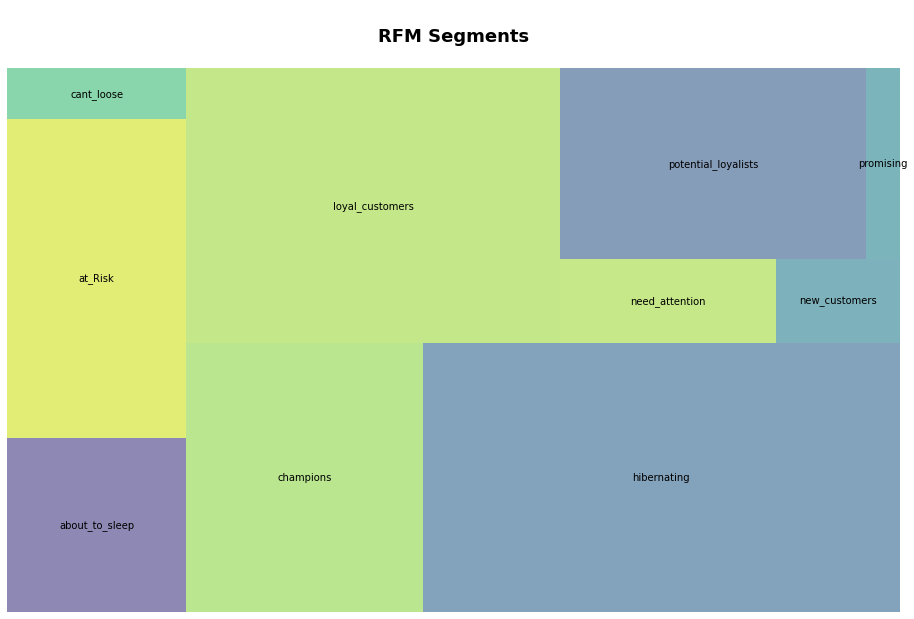

In [56]:
#Create our plot and resize it.
segments = ['about_to_sleep',
                     'at_Risk',
                     'cant_loose',
                     'champions',
                     'hibernating', 
                     'loyal_customers',
                     'need_attention',
                     'new_customers',
                     'potential_loyalists',
                     'promising']

#colors = ['red','green','yellow','blue','gray','black','orange','purple','cyan','pink']

fig = plt.gcf()
ax = fig.add_subplot()
norm = mcolors.Normalize(vmin=mini,vmax=maxi)
colors = [cmap(norm(value)) for value in rfm_df.reset_index()['client_code']]
fig.set_size_inches(16, 10)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label = segments, alpha=.6)
plt.title("\nRFM Segments\n",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

In [13]:
rfm_df_cl = rfm_df[rfm_df['segment']=='cant_loose'].reset_index().sort_values('monetary',ascending = False)
rfm_df_cl['money_perc_cum'] = rfm_df_cl['monetary'].cumsum()/rfm_df_cl['monetary'].sum()
rfm_df_cl['pareto_money'] = np.where(rfm_df_cl['money_perc_cum']<=0.8,'80%_group','20%_group')

In [14]:
rfm_df_cl

,client_code,recency,frequency,monetary,receny_score,frequency_score,monetary_score,rfm_score,segment,money_perc_cum,pareto_money
5,204264,29,351,3064078,2,5,5,25,cant_loose,0.184710,80%_group
6,204269,35,433,2554181,2,5,5,25,cant_loose,0.338681,80%_group
1,203424,199,394,2495920,1,5,5,15,cant_loose,0.489141,80%_group
0,203379,32,512,2340096,2,5,4,25,cant_loose,0.630207,80%_group
2,203896,29,418,2231202,2,5,4,25,cant_loose,0.764709,80%_group
4,204035,33,333,2229532,2,5,4,25,cant_loose,0.899110,20%_group
3,203897,27,397,1673620,2,5,4,25,cant_loose,1.000000,20%_group


In [16]:
rfm_df_cl['receny_score'] = rfm_df_cl['receny_score'].astype(str).astype(int)
rfm_df_cl['frequency_score'] = rfm_df_cl['frequency_score'].astype(str).astype(int)
rfm_df_cl['monetary_score'] = rfm_df_cl['monetary_score'].astype(str).astype(int)


df_1 = rfm_df_cl.groupby('pareto_money').agg(total_money = ('monetary', 'sum'),
                                     total_customers = ('client_code',pd.Series.nunique),
                                     total_frecuency = ('frequency','sum'),
                                     mean_recency = ('recency','mean'),
                                     max_recency = ('recency','max'),
                                     mean_monetary_score = ('monetary_score','mean'),
                                     mean_recency_score = ('receny_score','mean'),
                                     mean_frecuency_score = ('frequency_score','mean'))

df_1['%_customers'] = df_1['total_customers']/df_1['total_customers'].sum()*100
df_1['avg_purchase'] = df_1['total_money']/df_1['total_frecuency']

df_1.sort_values('pareto_money',ascending = False).T

pareto_money,80%_group,20%_group
total_money,1.268548e+07,3.903152e+06
total_customers,5.000000e+00,2.000000e+00
total_frecuency,2.108000e+03,7.300000e+02
mean_recency,6.480000e+01,3.000000e+01
max_recency,1.990000e+02,3.300000e+01
mean_monetary_score,4.600000e+00,4.000000e+00
mean_recency_score,1.800000e+00,2.000000e+00
mean_frecuency_score,5.000000e+00,5.000000e+00
%_customers,7.142857e+01,2.857143e+01
avg_purchase,6.017778e+03,5.346784e+03


# Market Basket Analysis

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [60]:
trx_cenabast['purchase_code'] = trx_cenabast.client_code.apply(str) + trx_cenabast.delivery_date.dt.year.apply(str) + trx_cenabast.delivery_date.dt.month.apply(str) + trx_cenabast.delivery_date.dt.day.apply(str)

In [61]:
trx_cenabast.head(5)

,molecule_code,dox_commercial,Material,Denominación,Solicitante,pharmacy_name,client_code,Fecha documento,mes,Año,...,prod_price,Precio Máximo Venta al Público,Precio Promedio Ponderado Retail,lab_name,Region,Comuna,Puesto de Descarga,Latitude,Longitude,purchase_code
0,100000903,306344037,500011462,PROLOPA 200/50 MG FRA 30 CM,77208124,FARMACIAS DEL SUR SPA,204264,2021-08-09,8,2021,...,4087,7062,23441,ROCHE CHILE LIMITADA,IX Región de La Araucanía,TEMUCO,LOS QUIMICOS 55,-38.716828,-72.650249,2042642021.08.019.0
1,100000713,306344037,500012180,GEMFIBROZILO 300 MG CAJ 30 CM REC,77208124,FARMACIAS DEL SUR SPA,204264,2021-08-09,8,2021,...,2044,3606,3450,77596940 LABORATORIO CHILE S.A.,IX Región de La Araucanía,TEMUCO,LOS QUIMICOS 55,-38.716828,-72.650249,2042642021.08.019.0
2,100000713,306344037,500011435,GEMFIBROZILO 300 MG CAJ 30 CP,77208124,FARMACIAS DEL SUR SPA,204264,2021-08-09,8,2021,...,1948,3692,3450,77596940 LABORATORIO CHILE S.A.,IX Región de La Araucanía,TEMUCO,LOS QUIMICOS 55,-38.716828,-72.650249,2042642021.08.019.0
3,100000382,306344037,500011924,CITALOPRAM 20 MG CAJ 30 CM,77208124,FARMACIAS DEL SUR SPA,204264,2021-08-09,8,2021,...,955,2000,5872,PHARMATRADE S.A.,IX Región de La Araucanía,TEMUCO,LOS QUIMICOS 55,-38.716828,-72.650249,2042642021.08.019.0
4,100001970,306344036,500011720,NOVORAPID 100U/ML SOL INY 10ML CAJ 1 FAM,77208124,FARMACIAS DEL SUR SPA,204264,2021-08-09,8,2021,...,15280,24450,10840,NOVO NORDISK FARMACEUTICAL LTDA,IX Región de La Araucanía,TEMUCO,LOS QUIMICOS 55,-38.716828,-72.650249,2042642021.08.019.0


In [67]:
basket_plus = trx_cenabast.groupby(['purchase_code','molecule_code'])['cantidad real'].sum().unstack().reset_index().fillna(0).set_index('purchase_code')

#basket_plus['purchase_code'] = basket_plus.client_code.apply(str) + basket_plus.delivery_date.dt.year.apply(str) + basket_plus.delivery_date.dt.month.apply(str) + basket_plus.delivery_date.dt.day.apply(str)
#s3 = ''.join([s1, s2])

In [68]:
basket_plus

molecule_code,100000003,100000009,100000013,100000014,100000021,100000022,100000028,100000030,100000032,100000034,...,100005310,100005314,100005319,100005340,100005482,100005501,100005503,100005506,100005592,100006477
purchase_code,,,,,,,,,,,,,,,,,,,,,
2033272020.010.022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2033272020.011.016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2033272020.011.024.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2033272020.012.020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2033272020.012.026.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047202022.03.027.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2047202022.03.028.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2047202022.03.031.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_encode_plus = basket_plus.applymap(encode_units)
basket_encode_plus

molecule_code,100000003,100000009,100000013,100000014,100000021,100000022,100000028,100000030,100000032,100000034,...,100005310,100005314,100005319,100005340,100005482,100005501,100005503,100005506,100005592,100006477
purchase_code,,,,,,,,,,,,,,,,,,,,,
2033272020.010.022.0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2033272020.011.016.0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2033272020.011.024.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2033272020.012.020.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2033272020.012.026.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047202022.03.027.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2047202022.03.028.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2047202022.03.031.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Filter The Transaction : Bought More Than 1 Items Only

In [73]:
basket_filter_plus = basket_encode_plus[(basket_encode_plus > 0).sum(axis=1) >= 2]
basket_filter_plus

molecule_code,100000003,100000009,100000013,100000014,100000021,100000022,100000028,100000030,100000032,100000034,...,100005310,100005314,100005319,100005340,100005482,100005501,100005503,100005506,100005592,100006477
purchase_code,,,,,,,,,,,,,,,,,,,,,
2033272020.010.022.0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2033272020.011.016.0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2033272020.012.020.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2033272020.012.026.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2033272020.07.027.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047202022.03.027.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2047202022.03.028.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2047202022.03.031.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Apply the Apriori Algorithm

In [72]:
from mlxtend.frequent_patterns import apriori

In [81]:
frequent_itemsets_plus = apriori(basket_filter_plus, min_support=0.15,
                                    use_colnames=True).sort_values('support',ascending=False).reset_index(drop = True)

#frequent_itemsets_plus['length'] = frequent_itemsets_plus['itemsets'].apply(lambda x: len(x))

frequent_itemsets_plus

,support,itemsets
0,0.159161,(100003264)


In [83]:
https://medium.com/@jihargifari/how-to-perform-market-basket-analysis-in-python-bd00b745b106

SyntaxError: invalid syntax (Temp/ipykernel_22212/2068338139.py, line 1)